
## MaxwellFDFD Data download
1. download data from link
2. make directory
3. unzip dataset


In [1]:
!curl -L -o maxwellfdfd.zip https://drive.google.com/uc?id=1Gs9Per_unwdmlXufDxmYEgLAve0ep8Xx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:05 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:06 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:07 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:08 --:--:--     0
  0     0    0     0    0     0      0      0 --:--

In [2]:
!mkdir maxwellfdfd
!unzip maxwellfdfd.zip -d ./maxwellfdfd

'unzip'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


## ML(Random Forest regressor):
1. create model for Multi-output Random Forest regressor

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

In [7]:
import os
data_dir = os.path.join(os.getcwd(), 'maxwellfdfd')
data_dir

'E:\\cdal\\edu\\display-ai-convergence\\maxwellfdfd'

In [8]:
DATASETS_TRAIN = [
    'binary_501',
    'binary_502',
    'binary_503',
    'binary_504',
    'binary_505',
    'binary_506',
    'binary_507',
    'binary_508',
    'binary_509',
    'binary_510',
    'binary_511',
    'binary_512',
    'binary_1001',
    'binary_1002',
    'binary_1003',
]

DATASETS_TEST = [
    'binary_new_test_501',
    'binary_new_test_1501',
    'binary_test_1101',
]

def cem_dataset(train=True):
  if train:
    DATAPATH = os.path.join(data_dir, 'train')
    DATASETS = DATASETS_TRAIN
  else:
    DATAPATH = os.path.join(data_dir, 'test')
    DATASETS = DATASETS_TEST

  input_data = []
  targets = []
  # load Train dataset
  for data in DATASETS:
    dataframe = pd.read_csv(os.path.join(DATAPATH, '{}.csv'.format(data)), delim_whitespace=False, header=None)
    dataset = dataframe.values

    # split into input (X) and output (Y) variables
    fileNames = dataset[:, 0].astype(int)
    input_data.extend(fileNames)

    # 1. first try max
    dataset[:, 1:25] /= 2767.1

    # 2. Classification or Regression
    labels = dataset[:, 1:25]
    targets.extend(labels)

  print(f'Data Loading Finished. len : {len(input_data)}')
  return pd.DataFrame(input_data), pd.DataFrame(targets)


In [9]:
X_train, y_train = cem_dataset(train=True)

Data Loading Finished. len : 9000


In [10]:
X_test, y_test = cem_dataset(train=False)

Data Loading Finished. len : 3000


In [11]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100))

In [12]:
model.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor())

In [13]:
y_pred = model.predict(X_test)
y_pred_df=pd.DataFrame(y_pred)

In [14]:
mean_squared_error(y_test, y_pred)

0.018226354358752365

In [15]:
mean_absolute_error(y_test, y_pred)

0.106565944245211

In [16]:
r2_score(y_test, y_pred)

0.23395499943043122

Text(0, 0.5, 'pred')

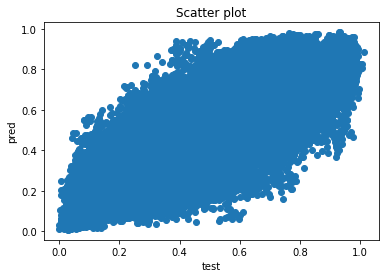

In [17]:
plt.scatter(y_test, y_pred)
plt.title('Scatter plot')
plt.xlabel('test')
plt.ylabel('pred')